<a href="https://colab.research.google.com/github/Faig22/dogs_and_cats_classification/blob/main/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [1]:
import zipfile # Библиотека для работы с zip архивами
import os      # Библиотека для работы с фаловой системой 
import time    # Библиотека для работы со временем

from google.colab import drive # Модуль для работы с Google Disk

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torchvision import transforms

import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image


from tqdm import tqdm

## Загрузка данных

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Прописываем путь к файлу с архивом
zip_file = "drive/My Drive/Deep Learning projects/dogs_cats_images/training_set.zip"
zip_file_test = "drive/My Drive/Deep Learning projects/dogs_cats_images/test_set.zip"


# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

z1 = zipfile.ZipFile(zip_file_test, 'r')
z1.extractall()


# Просмотр результата разархивации
print(os.listdir())

['.config', 'test_set', 'drive', 'training_set', 'sample_data']


In [ ]:
# len(os.listdir('training_set/cats'))

4000

In [19]:
train_path = './training_set/' 
test_path = './test_set/'

In [20]:
cats_train_path = os.path.join(train_path, 'cats')
dogs_train_path = os.path.join(train_path, 'dogs')

cats_test_path = os.path.join(test_path, 'cats')
dogs_test_path = os.path.join(test_path, 'dogs')

In [30]:
# os.listdir(cats_train_path)

Визуализируем тренировочные данные

In [21]:
def image_visualization(path:str, number_of_image:int):
#     number_of_image = 5
    fig, ax = plt.subplots(ncols=number_of_image, figsize=(28,28))
    
    random_numbers = np.random.choice([i for i in os.listdir(path)], number_of_image, replace=False)

    for i in range(number_of_image):
        
        img = os.path.join(path, random_numbers[i])
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = img.astype(np.float32)
        img = img/255.0
        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
    
        ax[i].imshow(img)
        
        if 'cat' in path:
            ax[i].set_title('cat',fontsize=30)
        else:
            ax[i].set_title('dog', fontsize=30)
    
    return


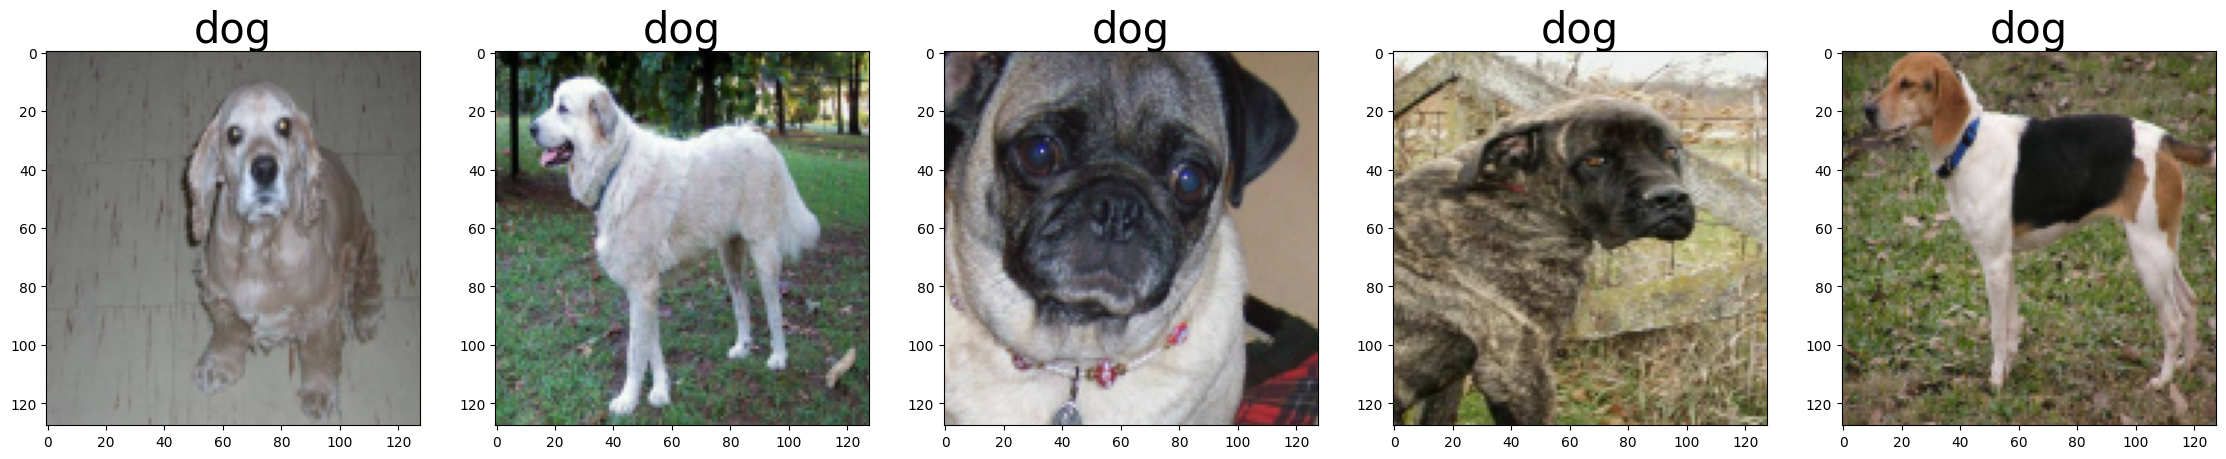

In [22]:
image_visualization(dogs_train_path, 5)

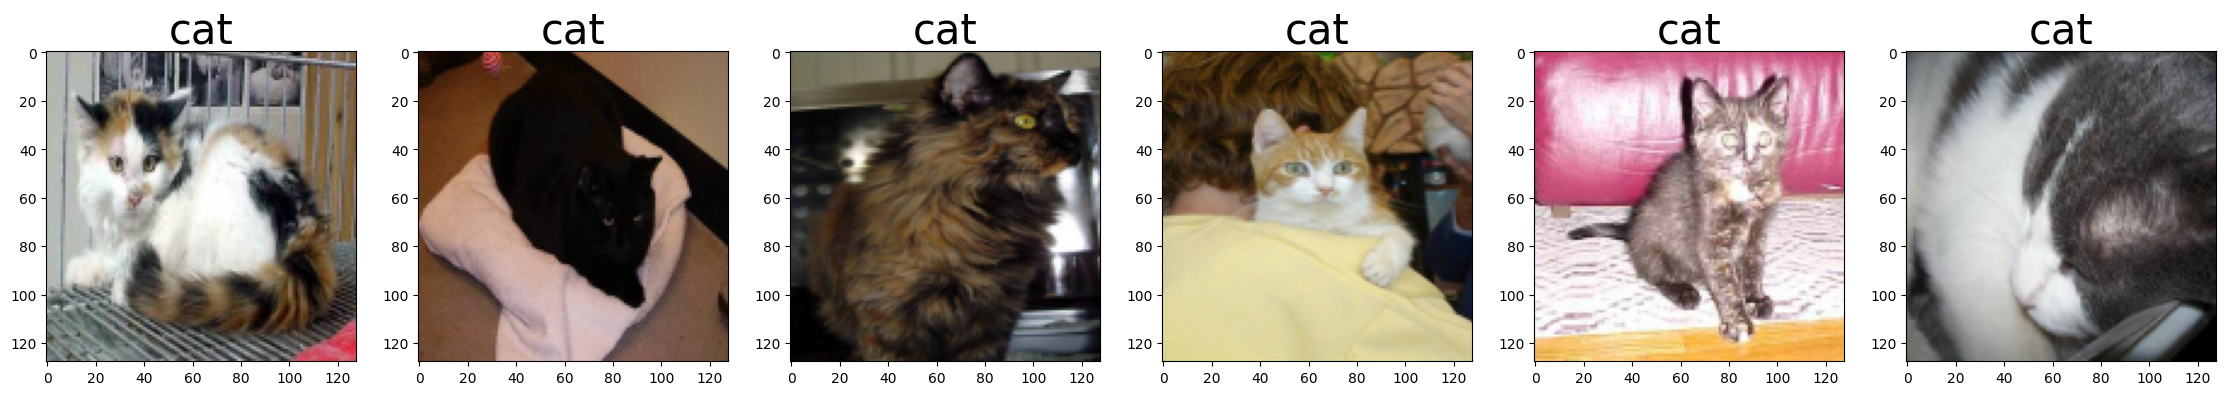

In [23]:
image_visualization(cats_train_path, 6)

## Создание датасета

Пропишем преобразования, которые необходимо применить к каждой фотографии. Сделаем размер **128** на **128**

In [24]:
train_transforms = transforms.Compose([
                             transforms.Resize((128, 128)),
                             transforms.ToTensor(),
                             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

test_transforms = transforms.Compose([
                             transforms.Resize((128, 128)),
                             transforms.ToTensor(),
                             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

Воспользуемся ***ImageFolder*** из библиотеки ***torchvision***

In [25]:
train_set = tv.datasets.ImageFolder(root = train_path, transform = train_transforms)
test_set = tv.datasets.ImageFolder(root = test_path, transform = test_transforms)



In [26]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=1, drop_last=True
                                          )
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=1, drop_last=True
                                          )

In [27]:
for i, l in train_loader:
    print(i.shape)
    print(l)
    break

torch.Size([32, 3, 128, 128])
tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 1])


In [28]:
len(train_loader)

250

## Инициализация модели

Составим свою моедль, состящую из 3-х свертчоных слоев и 3 линейных полносвязных слоев. В качестве пулинга будем использовать ***MaxPool***, 
а в качестве функции активации попробуем три различные функции (***ReLU***, ***LeakyReLU***, ***Tanh***). Обучим модель на каждой функции и выберем лучшую для итоговой модели

In [29]:
class MyNet(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()
        
        if activation == 'ReLU':
            self.act = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.act = nn.LeakyReLU(negative_slope=0.1)
        elif activation == 'Tanh':
            self.act = nn.Tanh()
        else:
            raise NotImplementedError('Не указана функция активации')
            
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        
        self.flat = nn.Flatten()
        
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64,
                                 kernel_size=(3,3), stride=1
                                ) # (64, 63, 63)
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128,
                                 kernel_size=(3,3), stride=1
                                ) # (128, 30, 30)
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256,
                                 kernel_size=(3,3), stride=1
                                ) # (256, 14, 14 )
        
        self.fc1 = nn.Linear(256*14*14, 256)
        self.fc2 = nn.Linear(256, 20)
        self.fc3 = nn.Linear(20, 2)
        
    def forward(self, x):
        
        x = self.conv1_1(x)
        x = self.act(x)
        x = self.pool(x)
        
        x = self.conv2_1(x)
        x = self.act(x)
        x = self.pool(x)
        
        x = self.conv3_1(x)
        x = self.act(x)
        x = self.pool(x)
        
        x = self.flat(x)
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        
        return x

In [30]:
model = MyNet(activation='ReLU')
model

MyNet(
  (act): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)

In [16]:
# def accuracy(pred, label, axis):
#     answer = F.softmax(pred.detach(), dim=1).argmax(1) == label.argmax(axis).cpu().numpy()
#     return answer.mean()

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Обучение модели

Обучим модель и сразу будем делать предсказания на тестовом датасете, в качестве оптимизатора возьмем ***Adam***,  в качестве лосса ***CrossEntropyLoss***

In [32]:
def train(model, train_loader, test_loader, epoch):
    loss = torch.nn.CrossEntropyLoss()
    # loss = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    test_loss_history = []
    test_acc_history = []
    model = model.to(device)
    
    for epoch in range(epoch):
        loss_val = 0
        acc_val = 0
        loss_val_test = 0
        acc_val_test = 0

        for img, label in (pbar := tqdm(train_loader)):

            model.train()
            # label = F.one_hot(label, 2).float()
            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad() # Обнулим градиенты весов

            pred = model(img)

            loss_value = loss(pred, label)
            loss_value.backward()
            loss_item = loss_value.item()
            loss_val += loss_item

            optimizer.step()
            # print(pred.argmax(dim=1).shape)
            # print(label.shape)
            # acc_current = accuracy(pred.cpu().float(), label, 1)
            acc_current = (pred.argmax(dim=1) == label.view(1, -1)).float().mean().data.cpu()
            acc_val += acc_current
            
            pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')  
        
#         model.eval()
        for X, y in test_loader:

            model.eval()
            X = X.to(device)
            y = y.to(device)
            test_pred = model(X)
            
            loss_value_test = loss(test_pred, y).data.cpu()
            loss_item_test = loss_value_test.item()
            loss_val_test += loss_item_test
        
            acc_current_test = (test_pred.argmax(dim=1) == y).float().mean().data.cpu()
            # acc_current_test = accuracy(test_pred.cpu().float(), y, 0)
            acc_val_test += acc_current_test
        
        
        test_loss_history.append(loss_val_test/len(test_loader))
        test_acc_history.append(acc_val_test/len(test_loader))
        
        print(f'EPOCH №{epoch + 1}')
        print(20*'--')
        print(f'train loss: {loss_val/(len(train_loader)):.2f}')
        print(f'train accuracy: {acc_val/(len(train_loader)):.2f}')
        print(30*'--')
        print(f'test loss: {loss_val_test/(len(test_loader)):.2f}')
        print(f'test accuracy: {acc_val_test/(len(test_loader)):.2f}')
        print(50*'--')

    return test_acc_history, test_loss_history

In [ ]:
accuracies = {}
losses = {}


accuracies['ReLU'], losses['ReLU'] = \
          train(model=MyNet(activation='ReLU'), 
                train_loader=train_loader,
                test_loader=test_loader,
                epoch=10)
          
accuracies['LeakyReLU'], losses['LeakyReLU'] = \
          train(model=MyNet(activation='LeakyReLU'), 
                train_loader=train_loader,
                test_loader=test_loader,
                epoch=10)
          
accuracies['Tanh'], losses['Tanh'] = \
          train(model=MyNet(activation='Tanh'), 
                train_loader=train_loader,
                test_loader=test_loader,
                epoch=10)

loss: 0.61607	accuracy: 0.562: 100%|██████████| 250/250 [00:37<00:00,  6.61it/s]


EPOCH №0
train loss: 0.68
train accuracy: 0.57
------------------------------------------------------------
test loss: 0.65
test accuracy: 0.61
----------------------------------------------------------------------------------------------------


loss: 0.50405	accuracy: 0.750: 100%|██████████| 250/250 [00:41<00:00,  6.06it/s]


EPOCH №1
train loss: 0.61
train accuracy: 0.66
------------------------------------------------------------
test loss: 0.54
test accuracy: 0.73
----------------------------------------------------------------------------------------------------


loss: 0.40364	accuracy: 0.812: 100%|██████████| 250/250 [00:37<00:00,  6.60it/s]


EPOCH №2
train loss: 0.52
train accuracy: 0.74
------------------------------------------------------------
test loss: 0.52
test accuracy: 0.75
----------------------------------------------------------------------------------------------------


loss: 0.42564	accuracy: 0.812: 100%|██████████| 250/250 [00:39<00:00,  6.39it/s]


EPOCH №3
train loss: 0.45
train accuracy: 0.79
------------------------------------------------------------
test loss: 0.49
test accuracy: 0.77
----------------------------------------------------------------------------------------------------


loss: 0.25220	accuracy: 0.906: 100%|██████████| 250/250 [00:41<00:00,  6.03it/s]


EPOCH №4
train loss: 0.37
train accuracy: 0.84
------------------------------------------------------------
test loss: 0.48
test accuracy: 0.79
----------------------------------------------------------------------------------------------------


loss: 0.25608	accuracy: 0.938: 100%|██████████| 250/250 [00:39<00:00,  6.30it/s]


EPOCH №5
train loss: 0.27
train accuracy: 0.88
------------------------------------------------------------
test loss: 0.53
test accuracy: 0.78
----------------------------------------------------------------------------------------------------


loss: 0.27452	accuracy: 0.938: 100%|██████████| 250/250 [00:39<00:00,  6.37it/s]


EPOCH №6
train loss: 0.16
train accuracy: 0.94
------------------------------------------------------------
test loss: 0.71
test accuracy: 0.78
----------------------------------------------------------------------------------------------------


loss: 0.09019	accuracy: 0.938: 100%|██████████| 250/250 [00:42<00:00,  5.89it/s]


EPOCH №7
train loss: 0.08
train accuracy: 0.97
------------------------------------------------------------
test loss: 1.05
test accuracy: 0.79
----------------------------------------------------------------------------------------------------


loss: 0.03149	accuracy: 1.000: 100%|██████████| 250/250 [00:46<00:00,  5.35it/s]


EPOCH №8
train loss: 0.03
train accuracy: 0.99
------------------------------------------------------------
test loss: 1.23
test accuracy: 0.77
----------------------------------------------------------------------------------------------------


loss: 0.17737	accuracy: 0.969: 100%|██████████| 250/250 [00:45<00:00,  5.44it/s]


EPOCH №9
train loss: 0.05
train accuracy: 0.98
------------------------------------------------------------
test loss: 1.01
test accuracy: 0.77
----------------------------------------------------------------------------------------------------


loss: 0.73495	accuracy: 0.406: 100%|██████████| 250/250 [00:39<00:00,  6.27it/s]


EPOCH №0
train loss: 0.67
train accuracy: 0.59
------------------------------------------------------------
test loss: 0.62
test accuracy: 0.65
----------------------------------------------------------------------------------------------------


loss: 0.42531	accuracy: 0.750: 100%|██████████| 250/250 [00:40<00:00,  6.11it/s]


EPOCH №1
train loss: 0.58
train accuracy: 0.69
------------------------------------------------------------
test loss: 0.59
test accuracy: 0.71
----------------------------------------------------------------------------------------------------


loss: 0.61028	accuracy: 0.625: 100%|██████████| 250/250 [00:38<00:00,  6.46it/s]


EPOCH №2
train loss: 0.50
train accuracy: 0.75
------------------------------------------------------------
test loss: 0.55
test accuracy: 0.73
----------------------------------------------------------------------------------------------------


loss: 0.45768	accuracy: 0.812: 100%|██████████| 250/250 [00:40<00:00,  6.22it/s]


EPOCH №3
train loss: 0.42
train accuracy: 0.80
------------------------------------------------------------
test loss: 0.48
test accuracy: 0.80
----------------------------------------------------------------------------------------------------


loss: 0.25523	accuracy: 0.938: 100%|██████████| 250/250 [00:38<00:00,  6.57it/s]


EPOCH №4
train loss: 0.33
train accuracy: 0.85
------------------------------------------------------------
test loss: 0.53
test accuracy: 0.79
----------------------------------------------------------------------------------------------------


loss: 0.28984	accuracy: 0.875: 100%|██████████| 250/250 [00:40<00:00,  6.19it/s]


EPOCH №5
train loss: 0.24
train accuracy: 0.90
------------------------------------------------------------
test loss: 0.55
test accuracy: 0.80
----------------------------------------------------------------------------------------------------


loss: 0.22964	accuracy: 0.875: 100%|██████████| 250/250 [00:38<00:00,  6.46it/s]


EPOCH №6
train loss: 0.14
train accuracy: 0.94
------------------------------------------------------------
test loss: 0.74
test accuracy: 0.80
----------------------------------------------------------------------------------------------------


loss: 0.12838	accuracy: 0.969: 100%|██████████| 250/250 [00:38<00:00,  6.43it/s]


EPOCH №7
train loss: 0.10
train accuracy: 0.96
------------------------------------------------------------
test loss: 0.83
test accuracy: 0.78
----------------------------------------------------------------------------------------------------


loss: 0.00365	accuracy: 1.000: 100%|██████████| 250/250 [00:40<00:00,  6.12it/s]


EPOCH №8
train loss: 0.06
train accuracy: 0.98
------------------------------------------------------------
test loss: 1.04
test accuracy: 0.80
----------------------------------------------------------------------------------------------------


loss: 0.01206	accuracy: 1.000: 100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


EPOCH №9
train loss: 0.05
train accuracy: 0.98
------------------------------------------------------------
test loss: 1.08
test accuracy: 0.79
----------------------------------------------------------------------------------------------------


loss: 0.65874	accuracy: 0.625: 100%|██████████| 250/250 [00:38<00:00,  6.42it/s]


EPOCH №0
train loss: 0.70
train accuracy: 0.52
------------------------------------------------------------
test loss: 0.68
test accuracy: 0.57
----------------------------------------------------------------------------------------------------


loss: 0.71323	accuracy: 0.469: 100%|██████████| 250/250 [00:37<00:00,  6.61it/s]


EPOCH №1
train loss: 0.68
train accuracy: 0.56
------------------------------------------------------------
test loss: 0.67
test accuracy: 0.58
----------------------------------------------------------------------------------------------------


loss: 0.71476	accuracy: 0.469: 100%|██████████| 250/250 [00:38<00:00,  6.42it/s]


EPOCH №2
train loss: 0.67
train accuracy: 0.58
------------------------------------------------------------
test loss: 0.67
test accuracy: 0.59
----------------------------------------------------------------------------------------------------


loss: 0.67623	accuracy: 0.531: 100%|██████████| 250/250 [00:39<00:00,  6.34it/s]


EPOCH №3
train loss: 0.67
train accuracy: 0.58
------------------------------------------------------------
test loss: 0.66
test accuracy: 0.60
----------------------------------------------------------------------------------------------------


loss: 0.65506	accuracy: 0.594: 100%|██████████| 250/250 [00:38<00:00,  6.44it/s]


EPOCH №4
train loss: 0.66
train accuracy: 0.60
------------------------------------------------------------
test loss: 0.67
test accuracy: 0.59
----------------------------------------------------------------------------------------------------


loss: 0.73564	accuracy: 0.500: 100%|██████████| 250/250 [00:40<00:00,  6.17it/s]


EPOCH №5
train loss: 0.66
train accuracy: 0.60
------------------------------------------------------------
test loss: 0.68
test accuracy: 0.57
----------------------------------------------------------------------------------------------------


loss: 0.65640	accuracy: 0.594: 100%|██████████| 250/250 [00:39<00:00,  6.38it/s]


EPOCH №6
train loss: 0.66
train accuracy: 0.60
------------------------------------------------------------
test loss: 0.66
test accuracy: 0.59
----------------------------------------------------------------------------------------------------


loss: 0.69124	accuracy: 0.594: 100%|██████████| 250/250 [00:40<00:00,  6.16it/s]


EPOCH №7
train loss: 0.66
train accuracy: 0.60
------------------------------------------------------------
test loss: 0.67
test accuracy: 0.60
----------------------------------------------------------------------------------------------------


loss: 0.69454	accuracy: 0.500: 100%|██████████| 250/250 [00:38<00:00,  6.50it/s]


EPOCH №8
train loss: 0.65
train accuracy: 0.61
------------------------------------------------------------
test loss: 0.65
test accuracy: 0.62
----------------------------------------------------------------------------------------------------


loss: 0.69394	accuracy: 0.531: 100%|██████████| 250/250 [00:40<00:00,  6.21it/s]


EPOCH №9
train loss: 0.66
train accuracy: 0.60
------------------------------------------------------------
test loss: 0.67
test accuracy: 0.58
----------------------------------------------------------------------------------------------------


Отобразим графики точности для моделей с разными функциями активации

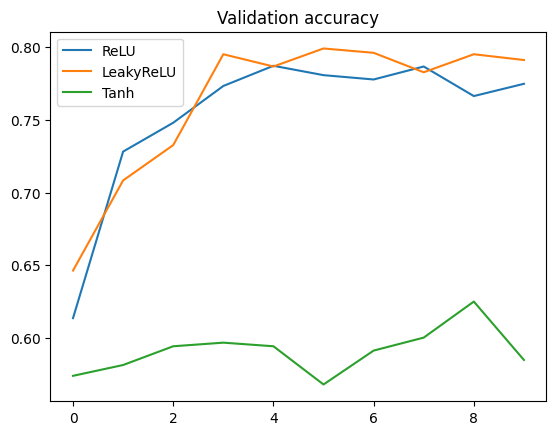

In [ ]:
for experiment in accuracies.keys():
    plt.plot(accuracies[experiment], label=experiment)

plt.legend()
plt.title('Validation accuracy')
plt.show()

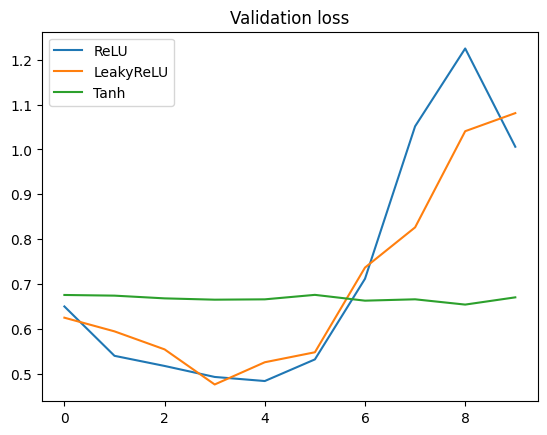

In [ ]:
for experiment in losses.keys():
    plt.plot(losses[experiment], label=experiment)

plt.legend()
plt.title('Validation loss')
plt.show()

После 5 эпох модель начинает переобучаться у ***LeakyReLU*** и ***ReLU***, гиперболический тангенс, показывает очень низкую точность и не переобучается в целом.

5 эпох с LeakyReLU достаточно для этой самодельной модели

### Сохранение модели на диск

In [33]:
LRmodel = MyNet(activation='LeakyReLU')
LRmodel

MyNet(
  (act): LeakyReLU(negative_slope=0.1)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)

In [ ]:
acc, loss = train(model=LRmodel, 
                  train_loader=train_loader,
                  test_loader=test_loader,
                  epoch=5)

loss: 0.60293	accuracy: 0.688: 100%|██████████| 250/250 [00:41<00:00,  6.09it/s]


EPOCH №1
----------------------------------------
train loss: 0.66
train accuracy: 0.60
------------------------------------------------------------
test loss: 0.59
test accuracy: 0.70
----------------------------------------------------------------------------------------------------


loss: 0.41428	accuracy: 0.844: 100%|██████████| 250/250 [00:43<00:00,  5.70it/s]


EPOCH №2
----------------------------------------
train loss: 0.54
train accuracy: 0.73
------------------------------------------------------------
test loss: 0.51
test accuracy: 0.76
----------------------------------------------------------------------------------------------------


loss: 0.50045	accuracy: 0.688: 100%|██████████| 250/250 [00:37<00:00,  6.70it/s]


EPOCH №3
----------------------------------------
train loss: 0.46
train accuracy: 0.78
------------------------------------------------------------
test loss: 0.48
test accuracy: 0.77
----------------------------------------------------------------------------------------------------


loss: 0.49010	accuracy: 0.750: 100%|██████████| 250/250 [00:39<00:00,  6.35it/s]


EPOCH №4
----------------------------------------
train loss: 0.38
train accuracy: 0.83
------------------------------------------------------------
test loss: 0.47
test accuracy: 0.79
----------------------------------------------------------------------------------------------------


loss: 0.18648	accuracy: 0.938: 100%|██████████| 250/250 [00:39<00:00,  6.38it/s]


EPOCH №5
----------------------------------------
train loss: 0.30
train accuracy: 0.87
------------------------------------------------------------
test loss: 0.52
test accuracy: 0.79
----------------------------------------------------------------------------------------------------


In [ ]:
model_save_name = 'MyModel.pt'
PATH = f"/content/drive/My Drive/My_save_models/Dogs_and_cats/{model_save_name}" 
torch.save(LRmodel.state_dict(), PATH)

## Предсказание на тестовых данных

Загрузим свою предобученную модель из диска

In [34]:
model_save_name = 'MyModel.pt'
PATH = f"/content/drive/My Drive/My_save_models/Dogs_and_cats/{model_save_name}" 
LRmodel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Путь, где хранятся изображения, которые модель еще не видела

In [35]:
examples_path = 'drive/My Drive/Deep Learning projects/dogs_cats_images/examples'

Напишем функцию, которая преобразует изображения, для того чтобы их можно было скармливать модели

In [36]:
def transform_pictures(path:str, number_of_images: int):
    
    try:
        img_path = [os.path.join(path, sorted(os.listdir(path))[i]) for i in range(number_of_images)]
        PIL_images = [Image.open(img) for img in img_path[:number_of_images]]
        test_batch = torch.stack([test_transforms(img).to(device) for img in PIL_images])
 
        return {'test_batch': test_batch,
                'images': PIL_images}

    except IndexError:
        print(f"num_of_pic {number_of_images} больше чем кол-во фотографий {len(os.listdir(path))} в папке")

Следующая функция делает предсказания и отображает изображения, которые модель получила на вход

In [55]:
def example_visualization(examples_path, model, num_of_pic):
    try:
        examples = transform_pictures(examples_path, num_of_pic)
    
        model = model.to(device)
        pred_logits = model(examples['test_batch'])
        pred_prob = F.softmax(pred_logits, dim=1).cpu().data.numpy()

        # NCOL = pred_logits.shape[0]
        fig, ax = plt.subplots(nrows = 1, ncols = num_of_pic, figsize=(15,12))

        for i in range(num_of_pic):
            
            ax[i].axis('off')
            ax[i].imshow(examples['images'][i])
            ax[i].set_title(f'{(100*pred_prob[i][0]):.0f}% cat {(100*pred_prob[i][1]):.0f}% dog', fontsize=10)

    except TypeError:
        print('Oперация применена к объекту несоответствующего типа.')
    

Видим, что модель с доменной областью справляется неплохо (уверенно определяет где собака, где кошка), но также модель уверена в своих предсказаниях на изображениях, где присутсвуют только люди или другие животные, что вполне забавно.  

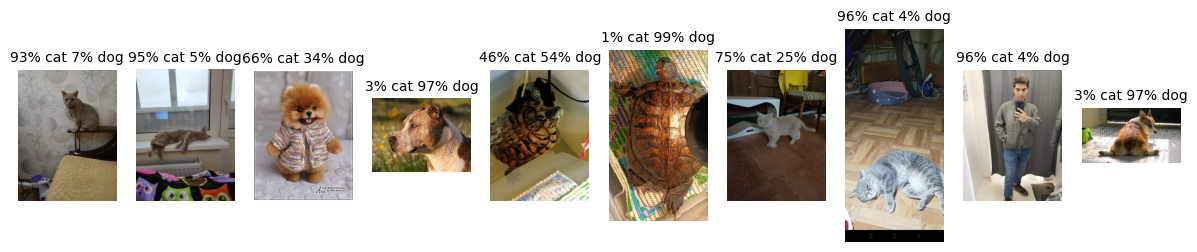

In [57]:
example_visualization(examples_path, LRmodel, 10)